In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from math import sqrt
from google.colab import files

In [2]:
def get_dataset(csv_path, sheet_name, list_inputs, date_index_column_name):
  df = pd.read_excel(csv_path, sheet_name=sheet_name)
  df_input = df.set_index(date_index_column_name)[list_inputs]
  dataset = df_input.to_numpy()
  return dataset

def normalize_dataset(dataset, min=0, max=1):
  scaler = MinMaxScaler(feature_range=(min, max))
  normalized_dataset = scaler.fit_transform(dataset)
  return scaler, normalized_dataset

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
  names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
  if i == 0:
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
  else:
    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
  agg.dropna(inplace=True)
 return agg.values

def drop_output_extra_columns(supervised_df, n_features):
  drop_columns_index = n_features-1
  supervised_df.drop(supervised_df.columns[-drop_columns_index:], axis=1, inplace=True)
  return supervised_df

def cut_training_test(values, training_percentage, n_features, lookback_window):
  training_data_len = math.ceil(len(values) * training_percentage)
  train = values[:training_data_len, :]
  test = values[training_data_len:, :]
  n_obs = lookback_window * n_features
  train_X, train_y = train[:, :n_obs], train[:, -n_features]
  test_X, test_y = test[:, :n_obs], test[:, -n_features]
  train_X = train_X.reshape((train_X.shape[0], lookback_window, n_features))
  test_X = test_X.reshape((test_X.shape[0], lookback_window, n_features))
  return train_X, train_y, test_X, test_y, training_data_len

def config_model(neurons, train_X):
  # design network
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))
  print(model.summary())
  return model

def inverse_norm(to_inverse, norm_initial_dataset, training_data_len, lookback_window, lookforward_window, scaler, type):
  if type == 'predictions':
    inversable_predictions = np.concatenate((to_inverse, norm_initial_dataset[training_data_len+lookback_window+lookforward_window-1:,1:]), axis=1)
    inverted = scaler.inverse_transform(inversable_predictions)
    inverted = inverted[:,0]
  else:
    inversable_y_test1 = norm_initial_dataset[training_data_len+lookback_window+lookforward_window-1:,:]
    inverted = scaler.inverse_transform(inversable_y_test1)
    inverted = inverted[:,0]
  return inverted

def get_plot(df, title):
  df_indexed = df.set_index('week')
  # to set the plot size
  plt.figure(figsize=(16, 8), dpi=150)

  # using plot method to plot open prices.
  # in plot method we set the label and color of the curve.
  df_indexed['actuals'].plot(label='actuals', color='orange')
  df_indexed['predictions'].plot(label='predictions', color='blue')

  # adding title to the plot
  plt.title(f'{title}')

  # adding Label to the x-axis
  plt.xlabel('Weeks')

  # adding legend to the curve
  plt.legend()

def get_comp_df_to_plot(csv_path, sheet_name, predictions):
  df_inicial = pd.read_excel(csv_path, sheet_name=sheet_name)
  df_inicial = df_inicial[['week','pld']]
  df_inicial = df_inicial.rename(columns={'pld':'actuals'})
  new_index = df_inicial.index.to_list()
  df_test_predictions = pd.DataFrame(data={'predictions':predictions})
  df_test_predictions.index = new_index[-len(df_test_predictions):]
  comp_df_to_plot = pd.concat([df_inicial, df_test_predictions], axis=1)
  return comp_df_to_plot

In [10]:
csv_path = 'FINAL_INPUTS_v2.xls'
sheet_name = 'southeast'
list_inputs = ['pld','load_energy','max_demand','ena','hidro_gen','thermo_gen','stored_energy','exports','imports']
date_index_column_name = 'ini_date'
n_features = len(list_inputs)
lookback_window = 1
lookforward_window = 1
training_percentage = 0.7
neurons = 100
epochs = 100

dataset = get_dataset(csv_path=csv_path,
                      sheet_name=sheet_name,
                      list_inputs=list_inputs,
                      date_index_column_name=date_index_column_name)

scaler, norm_dataset = normalize_dataset(dataset)

values = series_to_supervised(norm_dataset,n_in=lookback_window, n_out=lookforward_window)

train_X, train_y, test_X, test_y, training_data_len = cut_training_test(values, training_percentage, n_features, lookback_window)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((797, 1, 9), (797,), (341, 1, 9), (341,))

In [192]:
model = config_model(neurons, train_X)
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=epochs, callbacks=[cp])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 100)               44000     
                                                                 
 dense_44 (Dense)            (None, 25)                2525      
                                                                 
 dense_45 (Dense)            (None, 1)                 26        
                                                                 
Total params: 46,551
Trainable params: 46,551
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0707 - root_mean_squared_error: 0.2659

25/25 [==============================] - 9s 228ms/step - loss: 0.0699 - root_mean_squared_error: 0.2645 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2198
Epoch 2/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.2180

25/25 [==============================] - 6s 268ms/step - loss: 0.0493 - root_mean_squared_error: 0.2220 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1975
Epoch 3/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0345 - root_mean_squared_error: 0.1858

25/25 [==============================] - 5s 203ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1961
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2003
Epoch 5/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0141 - root_mean_squared_error: 0.1189 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2063
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0120 - root_mean_squared_error: 0.1098 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1995
Epoch 8/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1024

25/25 [==============================] - 6s 267ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1799
Epoch 9/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0983

25/25 [==============================] - 5s 209ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1688
Epoch 10/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.0938

25/25 [==============================] - 5s 201ms/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1579
Epoch 11/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0901

25/25 [==============================] - 7s 278ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1531
Epoch 12/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0845

25/25 [==============================] - 5s 211ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1452
Epoch 13/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0849

25/25 [==============================] - 7s 306ms/step - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1362
Epoch 14/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0837

25/25 [==============================] - 5s 204ms/step - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 15/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0809

25/25 [==============================] - 6s 263ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 16/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0793

25/25 [==============================] - 5s 205ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214
Epoch 17/100
18/25 [====================>.........] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0736

25/25 [==============================] - 6s 237ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 18/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214
Epoch 19/100
25/25 [==============================] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0769

25/25 [==============================] - 6s 254ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 20/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0780

25/25 [==============================] - 5s 221ms/step - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 21/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0730

25/25 [==============================] - 6s 252ms/step - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 22/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129
Epoch 23/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0760

25/25 [==============================] - 5s 203ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 24/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0743

25/25 [==============================] - 6s 234ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 25/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 26/100
20/25 [=======================>......] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0736

25/25 [==============================] - 6s 255ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1065
Epoch 27/100
25/25 [==============================] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0726

25/25 [==============================] - 6s 241ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 28/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 29/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 30/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 31/100
25/25 [==============================] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0720

25/25 [==============================] - 6s 246ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 32/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0740

25/25 [==============================] - 6s 241ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 33/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 34/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 35/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 36/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 37/100
25/25 [==============================] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0702

25/25 [==============================] - 6s 245ms/step - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 38/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 39/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1015
Epoch 40/100
25/25 [==============================] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0693

25/25 [==============================] - 6s 236ms/step - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 41/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029
Epoch 42/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 43/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1015
Epoch 44/100
25/25 [==============================] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0687

25/25 [==============================] - 5s 209ms/step - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 45/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0047 - root_mean_squared_error: 0.0687 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 46/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999
Epoch 47/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 48/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 49/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0102 - val_root_m

25/25 [==============================] - 6s 269ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0974
Epoch 51/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 52/100
25/25 [==============================] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0673

25/25 [==============================] - 5s 208ms/step - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 53/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0045 - root_mean_squared_error: 0.0667 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 54/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0977
Epoch 55/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0977
Epoch 56/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0678

25/25 [==============================] - 6s 253ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 57/100
20/25 [=======================>......] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0640

25/25 [==============================] - 5s 207ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963
Epoch 58/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 59/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0967
Epoch 60/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0977
Epoch 61/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0663

25/25 [==============================] - 5s 224ms/step - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963
Epoch 62/100
20/25 [=======================>......] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0649

25/25 [==============================] - 6s 247ms/step - loss: 0.0042 - root_mean_squared_error: 0.0652 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0962
Epoch 63/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 64/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0971
Epoch 65/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0666

25/25 [==============================] - 6s 241ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 66/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945
Epoch 67/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0043 - root_mean_squared_error: 0.0652 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0981
Epoch 68/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 69/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0041 - root_mean_squared_error: 0.0644 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 70/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0092 - val_root_m

25/25 [==============================] - 6s 266ms/step - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 73/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950
Epoch 74/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 75/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0981
Epoch 76/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 77/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0089 - val_root_m

25/25 [==============================] - 5s 208ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 80/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985
Epoch 81/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0627

25/25 [==============================] - 6s 264ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923
Epoch 82/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 83/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 84/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 85/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0962
Epoch 86/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0635

25/25 [==============================] - 5s 211ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923
Epoch 87/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 88/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0626

25/25 [==============================] - 6s 242ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 89/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 90/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 91/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0600

25/25 [==============================] - 6s 240ms/step - loss: 0.0036 - root_mean_squared_error: 0.0603 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 92/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0575

25/25 [==============================] - 6s 240ms/step - loss: 0.0036 - root_mean_squared_error: 0.0604 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 93/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0900
Epoch 94/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 95/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 96/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930
Epoch 97/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0595

25/25 [==============================] - 6s 251ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0872
Epoch 98/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 99/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 100/100
20/25 [=======================>......] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0630

25/25 [==============================] - 7s 291ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870


In [183]:
predictions = model.predict(test_X)

predictions = inverse_norm(to_inverse=predictions,
                          norm_initial_dataset=norm_dataset,
                          training_data_len=training_data_len,
                          lookback_window=lookback_window,
                          lookforward_window=lookforward_window,
                          scaler=scaler,
                          type='predictions')
actuals = inverse_norm(to_inverse=test_y,
                      norm_initial_dataset=norm_dataset,
                      training_data_len=training_data_len,
                      lookback_window=lookback_window,
                      lookforward_window=lookforward_window,
                      scaler=scaler, type='actuals')


11/11 [==============================] - 0s 4ms/step


In [184]:
comp_df_to_plot = get_comp_df_to_plot(csv_path, sheet_name, predictions)
comp_df_to_plot

,week,actuals,predictions
0,1,684.00,NaN
1,2,684.00,NaN
2,3,684.00,NaN
3,4,684.00,NaN
4,5,684.00,NaN
...,...,...,...
1134,1135,69.04,148.194695
1135,1136,69.04,136.024620
1136,1137,69.04,147.460407
1137,1138,69.04,153.302860


In [182]:
if lookforward_window == 1:
  title = f'Price predictions for the first week ahead ({sheet_name})'
if lookforward_window == 2:
  title = f'Price predictions for the second week ahead ({sheet_name})'
if lookforward_window == 3:
  title = f'Price predictions for the third week ahead ({sheet_name})'
if lookforward_window == 4:
  title = f'Price predictions for the fourth week ahead ({sheet_name})'
benchmark_df = comp_df_to_plot[1018:1045]
benchmark_df.to_csv(f'benchmark_df_{title}.csv')
files.download(f'benchmark_df_{title}.csv')

,week,actuals,predictions
1018,1019,297.43,301.633894
1019,1020,306.12,244.482667
1020,1021,215.56,277.108965
1021,1022,184.35,301.544261
1022,1023,152.10,293.155157
1023,1024,170.45,291.633359
1024,1025,173.37,289.944181
1025,1026,184.15,260.867134
1026,1027,119.64,238.835732
1027,1028,70.71,231.842261


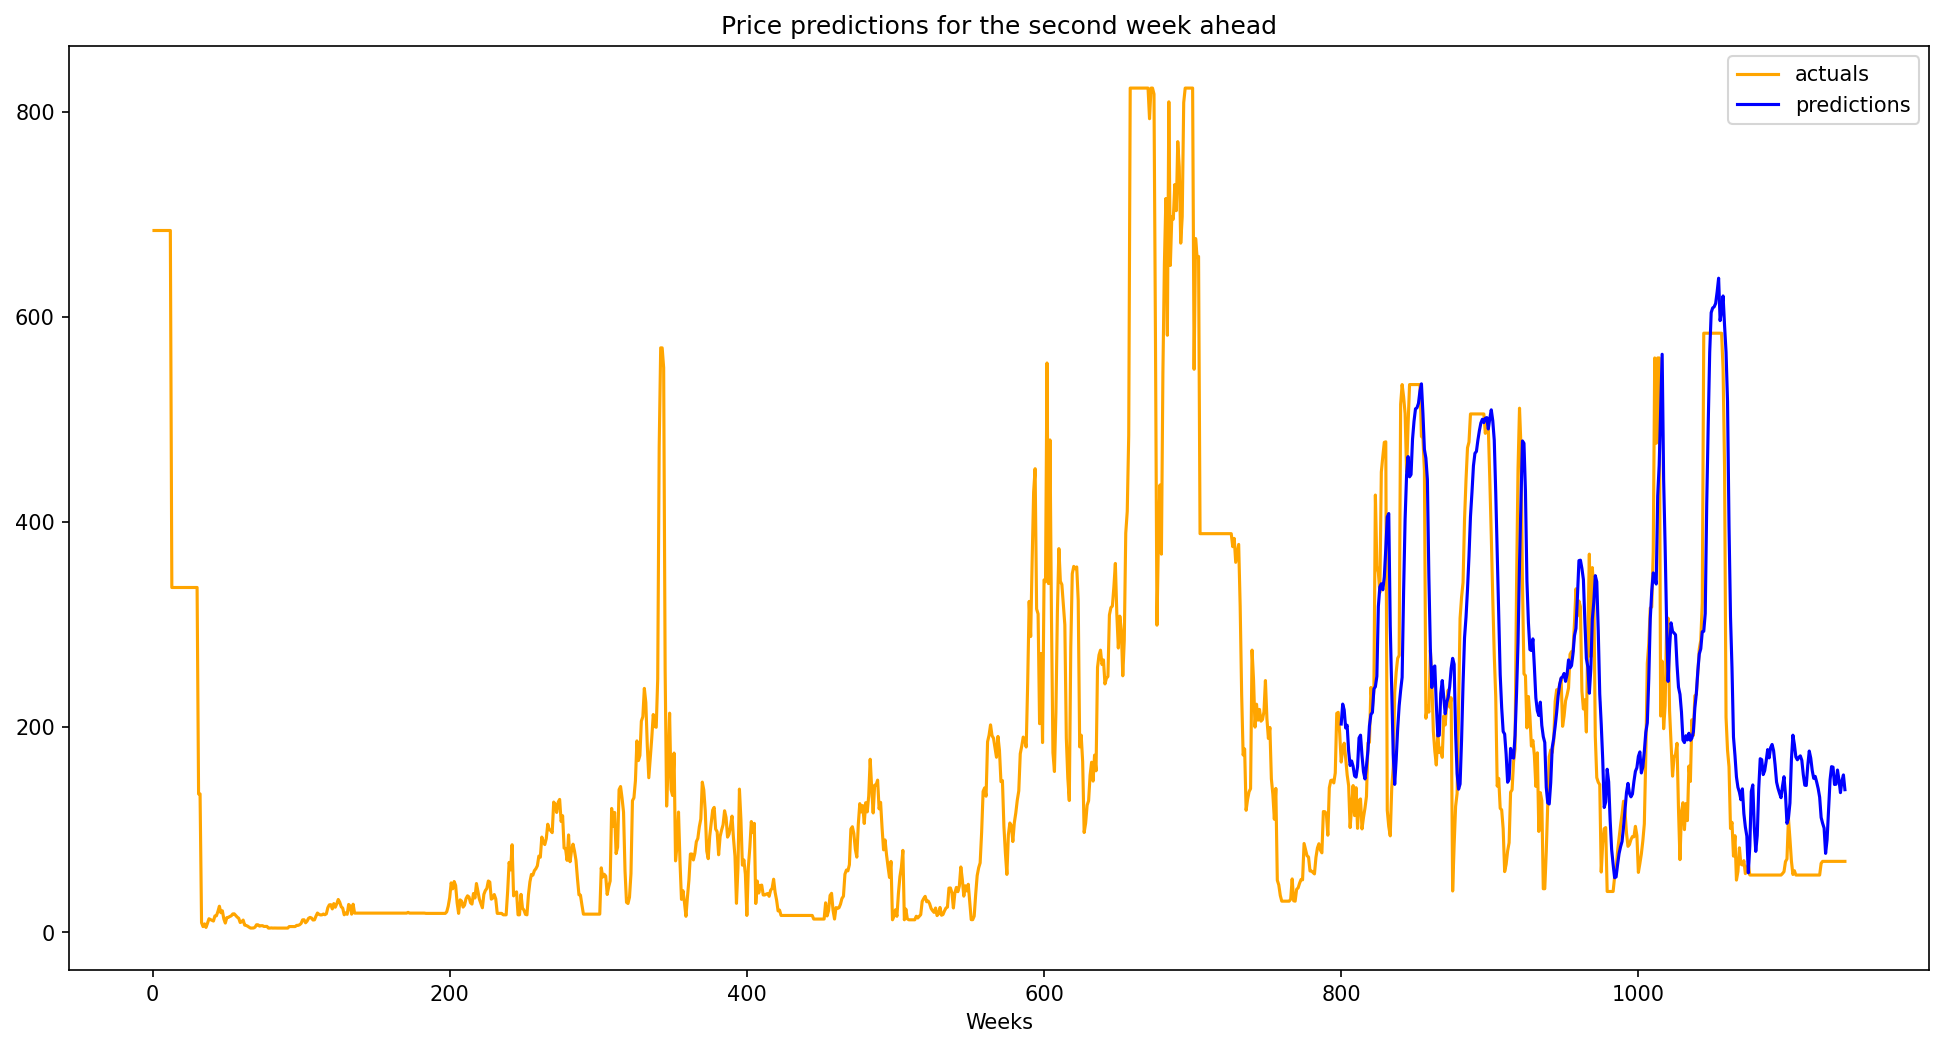

In [178]:
get_plot(comp_df_to_plot,title=title)

In [179]:
# get root mean sqaured error (RMSE)
rmse = sqrt(mse(actuals, predictions))
print('Predictions RMSE: %.3f' % rmse)

Predictions RMSE: 102.511


In [22]:
sheet_name = 'north'
df = pd.read_excel(csv_path, sheet_name=sheet_name)
df_input = df.set_index(date_index_column_name)[list_inputs]
df_input

,pld,load_energy,max_demand,ena,hidro_gen,thermo_gen,stored_energy,exports,imports
ini_date,,,,,,,,,
2001-06-30,684.00,2282.007202,2.619,2.223,2998.7,0.0,9.992,717.000,0.0
2001-07-07,684.00,2236.158333,2.514,2.007,2836.5,0.0,9.804,600.000,0.0
2001-07-14,684.00,2207.686310,2.487,1.866,2702.3,0.0,9.627,495.000,0.0
2001-07-21,684.00,2187.737500,2.463,1.732,2793.1,0.0,9.389,605.000,0.0
2001-07-28,684.00,2220.974405,2.898,1.629,2967.8,0.0,9.087,747.000,0.0
...,...,...,...,...,...,...,...,...,...
2023-03-25,69.04,6717.131149,7.493,32.588,15090.5,858.2,14.951,9271.000,0.0
2023-04-01,69.04,6650.716036,7.597,30.199,16481.8,1263.1,15.048,11.127,0.0
2023-04-08,69.04,6745.309375,7.636,29.455,14728.3,1687.1,15.006,9755.000,0.0


In [23]:
df_input[df_input.columns[0:]].corr()['pld'][:]

pld              1.000000
load_energy      0.302692
max_demand       0.296453
ena             -0.240569
hidro_gen       -0.124943
thermo_gen       0.573505
stored_energy   -0.113380
exports         -0.026585
imports         -0.040926
Name: pld, dtype: float64